## Extract text from notebooks
* Just markdown and source (maybe raw?)
* Use nbconvert to standardize version / extractions
* Keep cells in order
* TODO: which exceptions to catch?

In [2]:
import nbformat

NB_VERSION = 4

def extract_text(notebook_str):
    """ Extract code and markdown
    Args:
        * notebook_str - notebook as a string
    Returns:
        * str - select code and markdown source (and outputs)
    Pre:
        * notebook_str is well-formed per notebook version 4
        * 'cell_type' is defined for all cells
        * 'source' defined for all 'code' and 'markdown' cells
    Throws:
        * Anything nbformat.reads() can throw :( which is diverse and poorly
        documented, hence the `except Exception` in handler()
    Notes:
        * Deliberately decided not to index output streams and display strings
        because they were noisy and low value

    """
    formatted = nbformat.reads(notebook_str, as_version=NB_VERSION)
    text = []
    for cell in formatted.get('cells', []):
        if 'source' in cell and 'cell_type' in cell:
            if cell['cell_type'] == 'code' or cell['cell_type'] == 'markdown':
                text.append(cell['source'])

    return '\n'.join(text)

## Gather parseable notebooks in memory
If you have lots of notebooks or tiny amounts of RAM, use disk instead of RAM.

In [7]:
from os.path import basename
import glob
import traceback

nbs = glob.glob("/Users/karve/Desktop/tmpnbs/*.ipynb")

good_nbs = []
for n in nbs:
    with open(n, 'r') as f:
        data = f.read()
        try:
            outstr = extract_text(data)
            good_nbs.append(n)
            fname = basename(n)
            with open(f"extracts/{fname}", "w+") as f:
                f.write(outstr)
        except Exception as e:
            print(f"skipping {n}")

skipping /Users/karve/Desktop/tmpnbs/nb_348235.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_321981.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1115925.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1226543.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_397493.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_172449.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1252278.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_484295.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_281170.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_372557.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1037908.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_472574.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_751402.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_315098.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_987903.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1022553.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1197205.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1063377.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb

skipping /Users/karve/Desktop/tmpnbs/nb_737148.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_77830.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_576672.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_643702.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_294285.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_971109.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_946360.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1154353.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_347488.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1163984.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_663104.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_578466.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_415880.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1036970.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_319979.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_93909.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_227949.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_167390.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_58221

skipping /Users/karve/Desktop/tmpnbs/nb_28208.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1115206.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_843343.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_58784.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_169224.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_645563.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_68469.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_569268.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1061823.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1222469.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_376438.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_859262.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_800278.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_948605.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_253105.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_99620.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_991162.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_792124.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1250642

skipping /Users/karve/Desktop/tmpnbs/nb_256681.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_241256.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1245769.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_425290.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_64715.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_256538.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_772049.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_768993.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_526446.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_587917.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1080148.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_481570.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_958599.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_92460.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_77936.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_672138.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_431574.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_414551.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_657589.

skipping /Users/karve/Desktop/tmpnbs/nb_991365.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1137534.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_177721.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_792366.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_65398.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_327548.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_68242.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_31530.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1109358.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1053100.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1083998.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_655975.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_58253.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_555588.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_129192.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_188857.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1088554.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1203369.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1245

skipping /Users/karve/Desktop/tmpnbs/nb_519909.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_681860.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_180494.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_618923.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_304491.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_314187.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_558307.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_572975.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_481511.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_93893.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1156593.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1216709.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_873269.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_433663.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_199686.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_34403.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_275897.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_715173.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_369695

skipping /Users/karve/Desktop/tmpnbs/nb_1141241.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_158848.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_376995.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_2881.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_472342.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_95539.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1134212.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_982155.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_720444.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_794263.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_298284.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1090811.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_38520.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_568056.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_443353.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_134623.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1109281.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_997081.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_108666

skipping /Users/karve/Desktop/tmpnbs/nb_974471.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_694506.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_49269.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_303305.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1087640.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_757289.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_748576.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_713949.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_661250.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_994851.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1122355.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_489350.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1021911.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_336998.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_132237.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_667740.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1086913.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_672475.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_613

skipping /Users/karve/Desktop/tmpnbs/nb_703503.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_91344.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_681455.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_762564.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_210672.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1137182.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_892946.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1193662.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_238770.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_89113.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_554613.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_174430.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_82108.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_987304.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_29893.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_431227.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_913867.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_70336.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_903532.ip

skipping /Users/karve/Desktop/tmpnbs/nb_81166.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_895748.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_158009.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_101487.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_642562.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1099882.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_707080.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1155970.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_13838.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_532415.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_379385.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_616888.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_957879.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1071022.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_743839.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1064317.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_8865.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_238001.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_195077

skipping /Users/karve/Desktop/tmpnbs/nb_906832.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_465456.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_83545.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_806943.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_140921.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_898553.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_111250.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_334396.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_951978.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1209389.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1033161.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_890156.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_984312.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_8472.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1157278.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_498813.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_891156.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_460189.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_118918

skipping /Users/karve/Desktop/tmpnbs/nb_564680.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_419776.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_753920.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_891599.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_258045.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1158889.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_562134.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_375823.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_989072.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_418940.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_700752.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_363066.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_356179.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_581174.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_70953.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_990967.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_933740.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1136775.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_45201

skipping /Users/karve/Desktop/tmpnbs/nb_768705.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_653116.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1164491.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1201202.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_758751.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_691414.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_136470.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_552654.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1065131.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_405944.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1175187.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_203545.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_796030.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_436967.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_645254.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_364143.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_176678.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_298319.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_11

skipping /Users/karve/Desktop/tmpnbs/nb_122177.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_401116.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_107911.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_278289.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_183498.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1145074.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_576043.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_36023.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_80537.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_48703.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1127398.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_91827.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_232022.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1001147.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_129191.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1234597.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_567555.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1229633.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_54033

skipping /Users/karve/Desktop/tmpnbs/nb_173118.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_934848.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1007363.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_629212.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_478838.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_485781.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_640534.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_250743.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1018760.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_122995.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1185171.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_206922.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1235959.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_954328.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_777144.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_311855.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_10394.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_281349.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_407

skipping /Users/karve/Desktop/tmpnbs/nb_962987.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_751542.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_226032.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_169847.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_802747.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_258757.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1047587.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_43478.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1100356.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_152723.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_994108.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_51218.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_656960.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_229003.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_164306.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_863540.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1212315.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_12592.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_777434

skipping /Users/karve/Desktop/tmpnbs/nb_1157340.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_535843.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_847937.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_71643.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_608258.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_930099.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_139547.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_235860.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_811756.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_18120.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1236764.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_187881.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_976051.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_858577.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_513017.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1060775.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_457161.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1202156.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_7181

skipping /Users/karve/Desktop/tmpnbs/nb_1113473.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_546277.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1235899.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_278781.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1197694.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_99644.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1164387.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_964946.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_555417.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_793770.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_796582.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_942809.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_340040.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_121181.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1173966.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1211632.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_819257.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_814719.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1

skipping /Users/karve/Desktop/tmpnbs/nb_834221.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_984311.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1213256.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_666110.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_848632.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1194011.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1180324.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_553823.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_45667.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1133013.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_401953.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_332579.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_692113.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_667110.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_211279.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_906831.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1015936.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_800881.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_12

skipping /Users/karve/Desktop/tmpnbs/nb_658645.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1086912.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_439355.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_312102.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_498647.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_229754.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_223864.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1093549.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_728942.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_221780.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_480385.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_4800.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_284866.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_951842.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_395093.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1233943.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_160930.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_289941.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_40711

skipping /Users/karve/Desktop/tmpnbs/nb_1255829.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1189947.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_280637.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1038071.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_310568.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_779202.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1044427.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1012240.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_335124.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1038034.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_851141.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_518839.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1076705.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_345711.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_760354.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_826264.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_635734.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_185387.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb

skipping /Users/karve/Desktop/tmpnbs/nb_433800.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_364293.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1139511.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_377067.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_449591.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_961358.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_9168.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1011562.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_474332.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_620540.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_932161.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_821635.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_339692.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1123224.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_574838.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_29043.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_247412.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_132303.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_399751

skipping /Users/karve/Desktop/tmpnbs/nb_674405.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_218125.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_897788.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1117792.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_304049.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_745664.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1151077.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_991738.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1226084.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_612172.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_825868.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1106655.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_70064.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_396111.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1099377.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_477529.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_52615.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_13837.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_5894

skipping /Users/karve/Desktop/tmpnbs/nb_452533.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_337778.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_149597.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1167165.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_58631.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_258487.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_429059.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_906380.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_645844.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_199125.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1012797.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_955750.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_778304.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_129962.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_608897.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_877481.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_165523.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1118993.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_4961

skipping /Users/karve/Desktop/tmpnbs/nb_253189.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_857493.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_140357.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_600181.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_218322.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_111020.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_778654.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_158695.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1216292.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_848441.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_501686.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1019165.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_357562.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_824544.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_787922.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_770214.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_215947.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_211727.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_4290

skipping /Users/karve/Desktop/tmpnbs/nb_772792.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_723832.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_483198.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_138227.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_341109.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_537453.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_856796.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_573883.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_771679.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_698716.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_803613.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_218821.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_542368.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_565885.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_740943.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_246694.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1137703.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1224598.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1306

skipping /Users/karve/Desktop/tmpnbs/nb_1244915.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1091261.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_896961.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1045048.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_195102.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_890477.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1255091.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_865474.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1216157.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_974013.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1098149.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_27784.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1040597.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_362401.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_953490.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_208926.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_907550.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_572806.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_

skipping /Users/karve/Desktop/tmpnbs/nb_691763.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_303706.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_986271.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_380089.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_177633.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_709041.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_701369.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_417794.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_748665.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_489382.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_994085.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_345367.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1072181.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_438757.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_541884.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_841749.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_551100.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_250960.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_12543

skipping /Users/karve/Desktop/tmpnbs/nb_1242997.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_306493.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_37068.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_683862.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1213672.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_486388.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_547734.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1108784.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_630316.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_608396.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1210996.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_662317.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_738949.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_248929.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_194004.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_904048.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_566276.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_450968.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_119

skipping /Users/karve/Desktop/tmpnbs/nb_929319.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_332568.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_634943.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_822236.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1020713.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_467819.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1210174.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_702218.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1158417.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1097242.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1151012.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1242289.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_635668.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_822989.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_934429.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_629630.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_95551.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1007741.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_

skipping /Users/karve/Desktop/tmpnbs/nb_293930.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_898539.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_971087.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_663077.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_568046.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_676342.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1181425.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_925941.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1100358.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_824875.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_378402.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_164993.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_851748.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_817439.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_556107.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_353633.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1008907.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1178168.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_48

skipping /Users/karve/Desktop/tmpnbs/nb_65810.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_226323.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_574795.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_591614.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_947565.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_978424.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_258097.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_385206.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_263180.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_309876.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_157421.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_838190.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_146172.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_320172.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_715862.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_950316.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1106322.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_33847.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_603587.

skipping /Users/karve/Desktop/tmpnbs/nb_313188.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_560620.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_107772.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1185058.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_490661.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_426375.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_62447.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_611841.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_901384.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_528479.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1255478.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1102235.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_140356.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1013283.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_829726.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_158694.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_345303.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_687817.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_117

skipping /Users/karve/Desktop/tmpnbs/nb_1106886.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_331352.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1040614.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_49674.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_324067.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1135858.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_592421.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_145577.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_95100.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_933568.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1043317.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_58183.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_156562.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_363563.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_441088.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_437480.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_331527.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_612546.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_10134

skipping /Users/karve/Desktop/tmpnbs/nb_411222.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_384298.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_759741.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_171711.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_424378.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1175991.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_185386.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_269591.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1072921.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_451894.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_709473.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_605274.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1199106.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_349023.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1195448.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_919705.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1027960.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_877407.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_6

skipping /Users/karve/Desktop/tmpnbs/nb_267009.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_692805.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_428732.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_809736.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_220548.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_762127.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1247861.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_405056.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_876855.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_457012.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_132302.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_763964.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1212533.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_186525.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_556920.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_436088.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_690545.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_282444.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_6880

skipping /Users/karve/Desktop/tmpnbs/nb_966488.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_651832.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1216738.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_4237.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_870928.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_380546.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_509041.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1047986.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_969624.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_54455.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_53145.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_446194.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_192280.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_49448.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_748357.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_490888.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1119994.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_830326.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_478404.i

skipping /Users/karve/Desktop/tmpnbs/nb_1002342.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_812844.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_72586.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_952383.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_979526.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_689596.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_294910.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_237737.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_562240.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_524972.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_187719.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_782401.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_289527.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_9541.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_188548.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_819430.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_792152.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_218709.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_540730.i

skipping /Users/karve/Desktop/tmpnbs/nb_559174.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_521574.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_106247.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_963208.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_449366.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_428768.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1039646.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_806111.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_348794.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_458670.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1185238.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_800444.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1155632.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_189347.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_914294.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_295335.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_657950.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1187948.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_11

skipping /Users/karve/Desktop/tmpnbs/nb_16084.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_926746.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_960437.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_250592.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_510744.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1178627.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1046652.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_573241.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_851007.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1155900.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_573204.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_911717.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_224897.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_483510.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1110101.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_345939.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_902177.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_167138.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_108

skipping /Users/karve/Desktop/tmpnbs/nb_560168.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_568691.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_684086.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_877231.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_625145.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_619193.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_783643.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_931295.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_203046.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_247490.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_658323.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_700699.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1212922.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_1158774.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_251496.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_205556.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_237159.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_630091.ipynb
skipping /Users/karve/Desktop/tmpnbs/nb_4155

In [8]:
nbs

['/Users/karve/Desktop/tmpnbs/nb_348235.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_321981.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_1115925.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_1226543.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_397493.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_172449.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_1252278.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_484295.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_281170.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_372557.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_1037908.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_472574.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_751402.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_315098.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_987903.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_1022553.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_1197205.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_1063377.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_851968.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_909803.ipynb',
 '/Users/karve/Desktop/tmpnbs/nb_

## Build TF matrix, IDF vector

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(input='filename', preprocessor=extract_text)
X = vectorizer.fit_transform(good_nbs)

> The vectorizer's vocabulary contains all words it encountered, minus stop words

### Peek at what vectorizer learned

> Omit digit strings, since our ElasticSearch endpoint doesn't index them.

In [156]:
import re
vocab = {t:i for t,i in vectorizer.vocabulary_.items() if not re.fullmatch('\d+', t)}
len(vocab)

163959

> It's a long list, so let's just peek at the first few.

In [157]:
import itertools
{k:v for k,v in itertools.islice(vocab.items(), 0, 10)}

{'distance': 75735,
 'wordList': 145416,
 'for': 84035,
 'dist': 75701,
 'in': 91934,
 'range': 120310,
 'update': 141563,
 'print': 117599,
 'nextWord': 107612,
 'None': 38144}

> `vocab` maps each term to an index in the `idf_` array

In [160]:
idf = vectorizer.idf_
idf[0:10]

array([4.38700625, 4.4723661 , 6.89026204, 7.47804871, 6.44842929,
       8.39433944, 9.08748662, 8.68202151, 9.08748662, 8.68202151])

### Map vocabulary to IDF

In [161]:
import pandas as pd

t2idf = {t:idf[i] for t,i in vocab.items()}
# put it in a pandas dataframe
t2idf_ = pd.DataFrame(list(term2idf.items()), columns=['term', 'idf'])

In [162]:
t2idf_.head()

,term,idf
0,distance,3.867131
1,wordList,8.394339
2,for,1.230780
3,dist,4.769999
4,in,1.209142


In [163]:
asc_idf = t2idf_.sort_values('idf')

### Terms with low IDF
Are super common, present in almost all docs

In [164]:
asc_idf.head(10)

,term,idf
94,import,1.135223
56,as,1.175613
4,in,1.209142
2,for,1.230780
35,from,1.253688
7,print,1.425960
30,and,1.461892
25,the,1.465312
128,data,1.491848
120,of,1.500683


### Terms with high IDF
Are idiosynchractic; unique to a single doc

In [188]:
asc_idf.tail(10)

,term,idf
114334,Gleicher,9.087487
114333,gebrauch,9.087487
114332,Integrierender,9.087487
114329,nsm,9.087487
114328,Linksorthokomplemet,9.087487
114326,aq2,9.087487
114325,aq1,9.087487
114323,Funktionen,9.087487
114335,Ansazu,9.087487
177051,VeraCrio13,9.087487


### See how IDFs are distributed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77cf925e80>]],
      dtype=object)

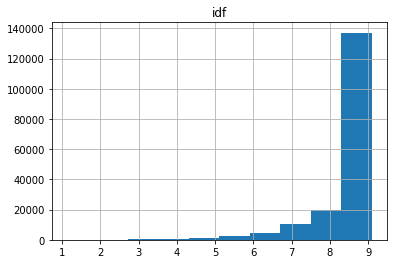

In [166]:
%matplotlib inline
asc_idf.hist(column='idf', bins=10)

### Grab 10 terms from each decile

In [179]:
import math
import numpy as np
import pickle

# flip the vocab so we can look up terms by index
i2t = {t:i for i,t in vocab.items()}
# sort by idf; only take terms in vocabulary
ascending_i = [i for i in np.argsort(idf) if i in i2t]

decile_size = math.floor(len(vocab) * .1)

decile_sample = {}
for d in range(0, 10):
    decile = ascending_i[decile_size * d: decile_size * (d+1)]
    random_i = np.random.choice(decile, 10, replace=False)
    decile_sample[d] = {i2t[j]:idf[j] for j in random_i}

with open("./dec_sample.pkl", 'wb') as f:
    pickle.dump(decile_sample, f)

In [180]:
decile_sample

{0: {'methods': 3.586228408390312,
  'resulting': 4.424047524822972,
  'basin': 6.22528573800557,
  'OSError': 7.295727149706984,
  'Sal': 7.072583598392774,
  'MAE': 6.602579969147039,
  'traverse': 7.008045077255203,
  'Independent': 6.645139583565834,
  'модель': 5.888813501384357,
  'processed': 5.621750716135312},
 1: {'zero_with_resv': 7.8347236504396705,
  'discount_factor': 7.988874330266929,
  'scale_color_brewer': 7.701192257815148,
  'nonzeroy': 7.478048706500939,
  'Пока': 7.583409222158765,
  'contemporary': 7.701192257815148,
  'train_lgb': 7.8347236504396705,
  'unlearned': 7.8347236504396705,
  'firstnum': 7.478048706500939,
  'Suspects': 7.988874330266929},
 2: {'Gott': 8.171195887060883,
  'occupants': 8.394339438375093,
  'dirpath': 8.171195887060883,
  'Remarque': 8.171195887060883,
  'set_next': 8.394339438375093,
  'delta_price1': 8.394339438375093,
  'numRows此圖合併了幾行': 8.171195887060883,
  'wordCountsGrouped': 8.171195887060883,
  'vocab_dict': 8.394339438375093,


> Neat. Good mix of languages (Russian, Chinese, English, German), numbers, variables, plain text.